Задание
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).
У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 
Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 
Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьер тут 
Описание данных
•	order_id - id заказа
•	delivery_time - время доставки в минутах
•	district - район доставки
•	experiment_group - экспериментальная группа



In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, levene
import pingouin as pg

In [3]:
df_experiment = pd.read_csv('experiment_lesson_4.csv')
df_experiment.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
df_experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.3+ KB


In [7]:
df_experiment.shape

(20196, 4)

In [9]:
df_experiment.district.unique()

array(['Purlieus', 'Central', 'Suburb'], dtype=object)

In [11]:
df_experiment.groupby('experiment_group', as_index=False).agg({'delivery_time': 'mean'})

,experiment_group,delivery_time
0,control,45.065101
1,test,39.046813


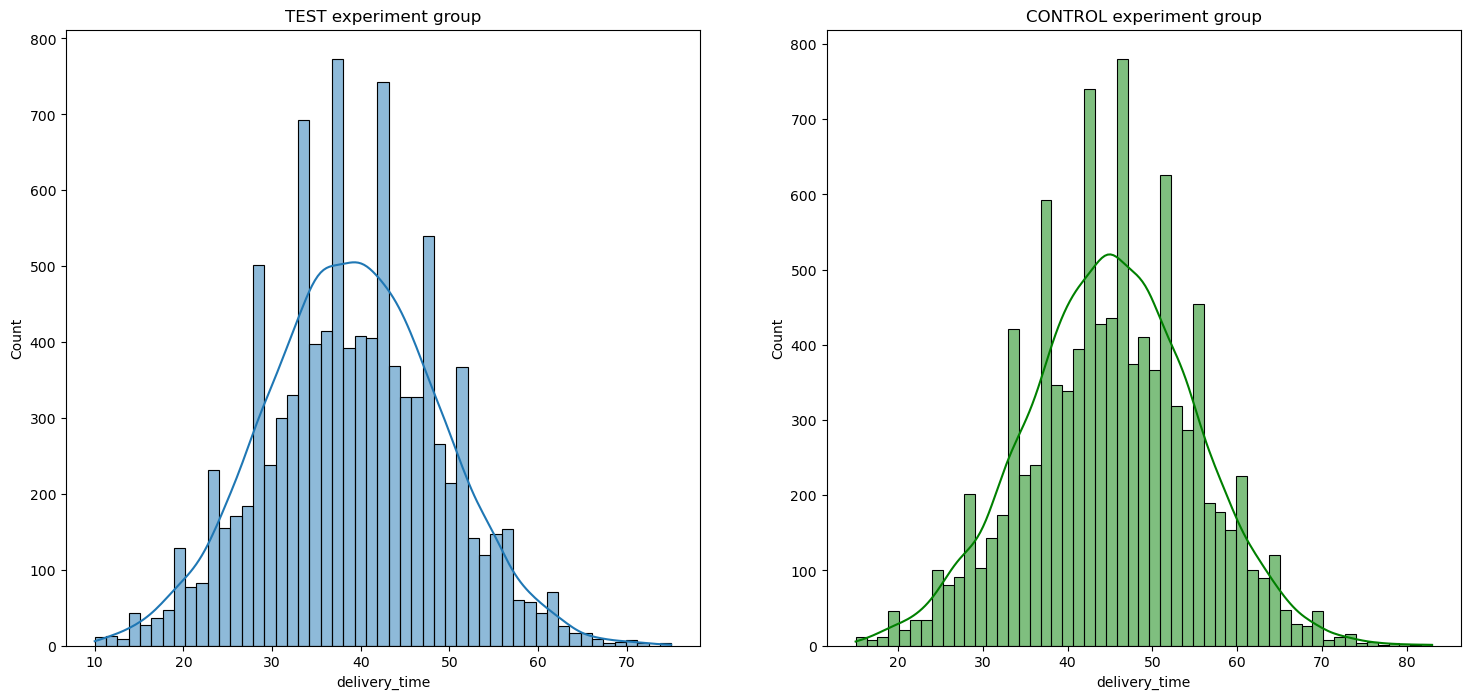

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.histplot(df_experiment.query('experiment_group == "test"').delivery_time, kde=True,ax=axes[0])
axes[0].set_title('TEST experiment group')
sns.histplot(df_experiment.query('experiment_group == "control"').delivery_time, kde=True, color='green', ax=axes[1])
axes[1].set_title('CONTROL experiment group')

plt.show()

In [15]:
#Проверка равенства дисперсий выборок. По учебникам рекомендуется использовать T-критерий Уэлча при нерваенстве  дисперсиц, которое оценивается по критерию Левена.
#Нулевая гипотеза Левена - дисперсии в двух группах равны, p-value < 0.05 значит отклоняем ее.
levene(df_experiment.query('experiment_group == "test"').delivery_time,
         df_experiment.query('experiment_group == "control"').delivery_time)

LeveneResult(statistic=0.2702281101900882, pvalue=0.6031844931083392)

In [32]:
x = df_experiment.query('experiment_group == "test"').delivery_time.sample(5000)
y = df_experiment.query('experiment_group == "control"').delivery_time.sample(5000)
print(pg.normality(x))
print(pg.normality(y))

                      W      pval  normal
delivery_time  0.998589  0.000217   False
                      W      pval  normal
delivery_time  0.998658  0.000352   False


Так же из проверки нормальности распределений выше,мы видим , что формально оба распределения таковыми не являются, поэтому следует применять раноговый критерий Манна-Уитни. Но он может не оч хорошо справляться с оч большими выборками, как в нашем случае. При таких условиях, самый практичный вариант — это Т-тест Уэлча, который учитывает неравенство дисперсий и подходит для больших выборок.

In [40]:
#Проще использовать сразу Т-критерий Уэлча, тк он более чем достаточно эффективен вне зависимости от результатов критерия Левена.
ttest_ind(df_experiment.query('experiment_group == "test"').delivery_time,
         df_experiment.query('experiment_group == "control"').delivery_time,
         equal_var=False)

TtestResult(statistic=-43.035552024241454, pvalue=0.0, df=20191.127787584755)

In [38]:
pg.mwu(df_experiment.query('experiment_group == "test"').delivery_time,
              df_experiment.query('experiment_group == "control"').delivery_time)

,U-val,alternative,p-val,RBC,CLES
MWU,33985060.0,two-sided,0.0,-0.333427,0.333286


Из результатов выше мы видим, что среднее время доставки  в тесте меньше , чем в контрольной группе. Так же p-value в Тесте Уэлча говорит нам о том, что данные значения являются статистически значимыми и есть смысл выкатить данные изменения на всех пользователей приложения. 

Попробуем посмотреть на данные по районам в отедельности, чтобы не упустить чего-то.

In [151]:
df = df_experiment.groupby(['experiment_group', 'district'], as_index=False).agg({'delivery_time': 'mean'})
df_pivot = df.pivot(columns='district', index='experiment_group', values='delivery_time')
df_pivot

district,Central,Purlieus,Suburb
experiment_group,,,
control,26.239163,45.125384,63.858255
test,24.608570,41.603986,59.348485


<Axes: xlabel='delivery_time', ylabel='Count'>

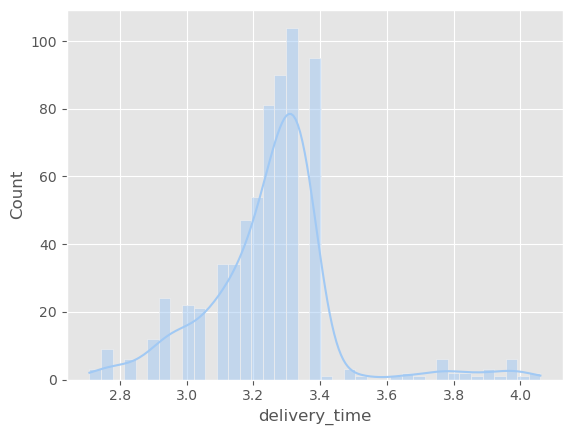

In [155]:
sns.histplot(np.log(df_experiment.query('district == "Central" and experiment_group == "control"').delivery_time), kde=True)

<Axes: xlabel='delivery_time', ylabel='Count'>

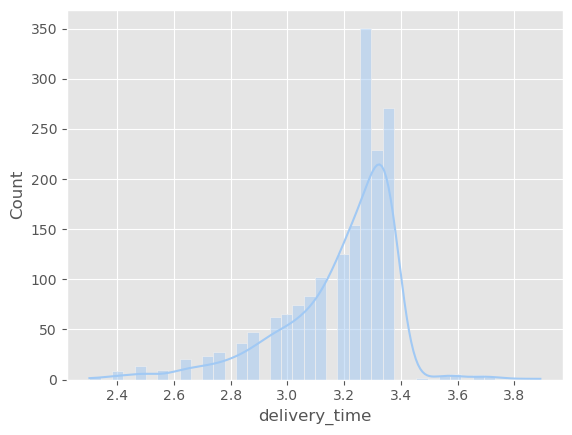

In [157]:
sns.histplot(np.log(df_experiment.query('district == "Central" and experiment_group == "test"').delivery_time), kde=True)

In [159]:
ttest_ind(np.log(df_experiment.query('district == "Central" and experiment_group == "test"').delivery_time),
         np.log(df_experiment.query('district == "Central" and experiment_group == "control"').delivery_time))

TtestResult(statistic=-6.940390600496612, pvalue=5.015582797734493e-12, df=2394.0)